In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import transformers
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.0 GB /  0.0 GB


In [2]:
# Initializing parameters

batch_size = 128     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

sequence_max_length = 250

In [3]:
train_dataset, test_dataset = torchtext.datasets.IMDB(split=('train', 'test'))

In [4]:

from torchtext.data.functional import to_map_style_dataset

train_dataset = to_map_style_dataset(train_dataset)
test_dataset = to_map_style_dataset(test_dataset)

In [5]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# inputs

inputs = tokenizer.encode_plus(
                    'Hello, my dog is cute', 
                    None,
                    add_special_tokens=True,
                    max_length = 20,
                    truncation = True,
                    padding='max_length',
                    return_tensors="pt"               
                )

inputs

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [6]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] hello, my dog is cute [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [7]:
# dbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
# res = dbert(inputs['input_ids'],inputs['attention_mask'])

In [8]:
# torch.mean(res.last_hidden_state, 1).shape

In [9]:
# print(dbert)



In [10]:
text_pipeline = lambda x: tokenizer.encode_plus(
                    x, 
                    None,
                    add_special_tokens=True,
                    max_length = sequence_max_length,
                    truncation = True,
                    padding='max_length'                    
                )
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [11]:
def collate_batch(batch):
     inputs = tokenizer.batch_encode_plus(
                    [text for _, text in batch],
                    add_special_tokens=True,
                    max_length = sequence_max_length,
                    truncation = True,
                    padding='max_length',
                    return_tensors="pt"                    
               )
     input_ids = inputs['input_ids']
     attention_mask = inputs['attention_mask']

     labels = torch.tensor([label_pipeline(label) for label, _ in batch], dtype=torch.float32).unsqueeze(-1)
     return (input_ids, attention_mask), labels

In [12]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    num_workers=8,
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [13]:

for (input_ids, attention_masks), labels in train_dataloader:
    print("Shape of input_ids: ", input_ids.shape)
    print("Shape of attention_masks: ", attention_masks.shape)
    print("Labels : ", labels.shape)
    print("SAMPLE")
    print("Label: ",labels[0].item())
    print("Text:")
    print(tokenizer.decode(input_ids[0]))
    # print(X, y, o)
    break

Shape of input_ids:  torch.Size([128, 250])
Shape of attention_masks:  torch.Size([128, 250])
Labels :  torch.Size([128, 1])
SAMPLE
Label:  0.0
Text:
[CLS] diana guzman is an angry young woman. surviving an unrelenting series of disappointments and traumas, she takes her anger out on the closest targets. < br / > < br / > when she sees violence transformed and focused by discipline in a rundown boxing club, she knows she's found her home. < br / > < br / > the film progresses from there, as diana learns the usual coming - of - age lessons alongside the skills needed for successful boxing. michelle rodriguez is very good in the role, particularly when conveying the focused rage of a young woman hemmed in on all sides and fighting against not just personal circumstances but entrenched sexism. < br / > < br / > the picture could use some finesse in its direction of all the young actors, who pale in comparison to the older, more experienced cast. there are too many pauses in the script, wh

In [14]:
from torch import nn

class ClassifyNet(nn.Module):

    def __init__(self, num_class):
        super().__init__()
        self.dbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        modules = [self.dbert.embeddings, *self.dbert.transformer.layer[:5]] #Replace 5 by what you want
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False

        self.fc = nn.Linear(768, num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        x = self.dbert(input_ids, attention_mask)
        x = torch.mean(x.last_hidden_state, 1)
        
        x = self.dropout(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

In [15]:
a = torch.randn(32, 250, 16)
torch.mean(a, 1).shape

torch.Size([32, 16])

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, history, epoch):
    size = len(dataloader.dataset)
    accuracy = 0

    with tqdm(dataloader, unit="batch") as dl:
        for ((input_ids, attention_mask), y) in dl:
            dl.set_description(f"Training epoch {epoch}")

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)

            #FORWARD PASS
            pred = model(input_ids, attention_mask)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

            # if batch % 100 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as dl:
            for ((input_ids, attention_mask), y) in dl:
                dl.set_description(f"Testing epoch {epoch}")   

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                y = y.to(device)


                pred = model(input_ids, attention_mask)
                
                loss += loss_fn(pred, y).item()
                accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [17]:
emsize = 16
num_classes = 1

model = ClassifyNet(num_classes).to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
print(model)

ClassifyNet(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featur

In [19]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 7088641


In [20]:
epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for epoch in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history, epoch)
    test_loop(test_dataloader, model, loss_fn, history)

# Base model has 66363649 parameters
# Takes 2 hours to train on a 1660 Gfx card
# 786.82s/epoch (11 minutes) for training/testing

# 
# Just the final transformer + linear Layer (7088641 parameters)
# Takes an hour to train (~5 mins for training/testing)

Testing epoch 9: 100%|██████████| 196/196 [04:50<00:00,  1.48s/batch]


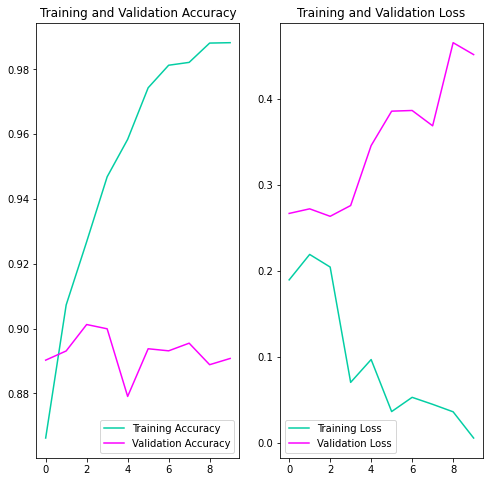

In [21]:
epochs_range = range(len(history['train_accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
